In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import os
from scipy import ndimage
from ml import SoftmaxRegression, KNN, CNN
%matplotlib inline

In [8]:
def read(path):
    X, y = sklearn.datasets.load_svmlight_file(path, 784, dtype=np.float32)
    return dict(images=X.todense(), labels=y)

def create_validation_set(data):
    # Split up training set to have a "testing" set with known labels
    data['test']['images'] = data['train']['images'][-100:]
    data['test']['labels'] = data['train']['labels'][-100:]
    data['train']['images'] = data['train']['images'][:-100]
    data['train']['labels'] = data['train']['labels'][:-100]
    return data

def add_morphed_data(data, zoom_range=np.arange(1.1, 1.4, 0.1), angle_range=range(-20, 20, 5)):
    # Rotating might throw a warning due to a new image shape
    np.seterr('ignore')
    # Create synthetic test data by applying zoom and rotation
    new_data = []
    for zoom_level in zoom_range:
        for angle in angle_range:
            new_data.append([clipped_zoom(rotate(x, angle), zoom_level) for x in data['train']['images']])
    print('{} mutations for each image'.format(len(new_data)))
    data['train']['images'] = np.concatenate(new_data)
    data['train']['labels'] = np.array(list(data['train']['labels'].data) * len(new_data))
    return data

def write(algo, labels):
    # Ensure that you're using unix newlines
    with open('./predictions_{}'.format(algo), 'w', newline='\n') as file_out:
        file_out.write(
            '\n'.join([str(int(x)) for x in labels])
        )

def plot_img(ax, img, title):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(title)

def plot_labels(ax, labels, title, color='#7070F0'):
    labels = np.array(labels, dtype=np.int)
    counts = np.bincount(labels)
    ax.bar(range(len(counts)), counts, color=color)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks(np.arange(len(counts)) + 0.4)
    ax.xaxis.set_ticklabels(np.arange(len(counts)))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['top'].set_visible(False)
    ax.set_title(title)

def compare_results(results):
    count = len(results) + 1
    colors = ['green', 'magenta', 'orange', 'purple']
    fig, axes = plt.subplots(1, count, figsize=(13, 2))
    plot_labels(axes[0], data['train']['labels'], 'Train')
    for ax, result, color in zip(axes.flat[1:], results, colors[:count-1]):
        title, labels = result
        plot_labels(ax, labels, title)
    fig.tight_layout()

def rotate(img, angle=10, reshape=True):
    if angle == 0:
        return img
    if reshape:
        img = img.reshape(28, 28)
        return ndimage.rotate(img, angle, reshape=False, prefilter=False).flatten()
    else:
        return ndimage.rotate(img, angle, reshape=False, prefilter=False)

# Source: http://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
def clipped_zoom(img, zoom_factor=1.3, reshape=True, **kwargs):
    if zoom_factor == 1:
        return img
    if reshape:
        img = img.reshape(28, 28)
    h, w = img.shape[:2]
    # width and height of the zoomed image
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))
    # for multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    # zooming out
    if zoom_factor < 1:
        # bounding box of the clip region within the output array
        top = (h - zh) // 2
        left = (w - zw) // 2
        # zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndimage.zoom(img, zoom_tuple, prefilter=False, **kwargs)
    # zooming in
    elif zoom_factor > 1:
        # bounding box of the clip region within the input array
        top = (zh - h) // 2
        left = (zw - w) // 2
        out = ndimage.zoom(img[top:top+zh, left:left+zw], zoom_tuple, prefilter=False, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    assert out.shape == img.shape
    if reshape:
        return out.flatten()
    return out

def execute_algo(algo, title, train=True, **kwargs):
    data = dict(train=read('digits/digit_train'), test=read('digits/digit_test'))
    if train:
        # Create synthetic test data by scaling and rotating
        images_rotated = [rotate(x) for x in data['train']['images']]
        images_rescaled = [rescale(x) for x in data['train']['images']]
        images_rotres = [rescale(x) for x in images_rotated]
        data['train']['images'] = np.concatenate([data['train']['images'], images_rotated, images_rescaled, images_rotres])
        data['train']['labels'] = np.array(list(data['train']['labels'].data) * 4)
        algo.fit(data['train']['images'], data['train']['labels'], **kwargs)
    predictions = algo.eval(data['test']['images'])

    # Exercise 11.1.a
    fig, axes = plt.subplots(1, 8, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        img = data['test']['images'][i].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title('{}: {:.0f}'.format(title, predictions[i]))
    fig.tight_layout()

    write('{}.txt'.format(title), predictions)

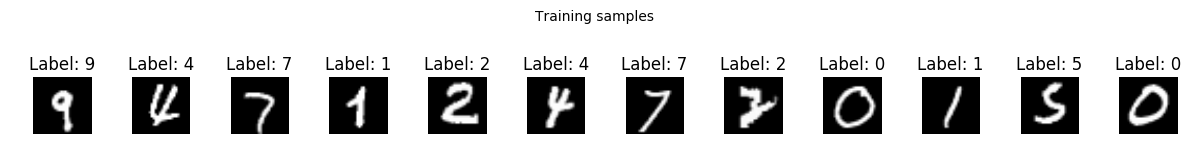

In [3]:
# Exercise 11.1a
data = dict(train=read('digits/digit_train'), test=read('digits/digit_test'))
fig, axes = plt.subplots(1, 12, figsize=(12, 2))
fig.suptitle('Training samples')
for i, ax in enumerate(axes.flat):
    img = data['train']['images'][i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title('Label: {:.0f}'.format(data['train']['labels'][i]))
fig.tight_layout()

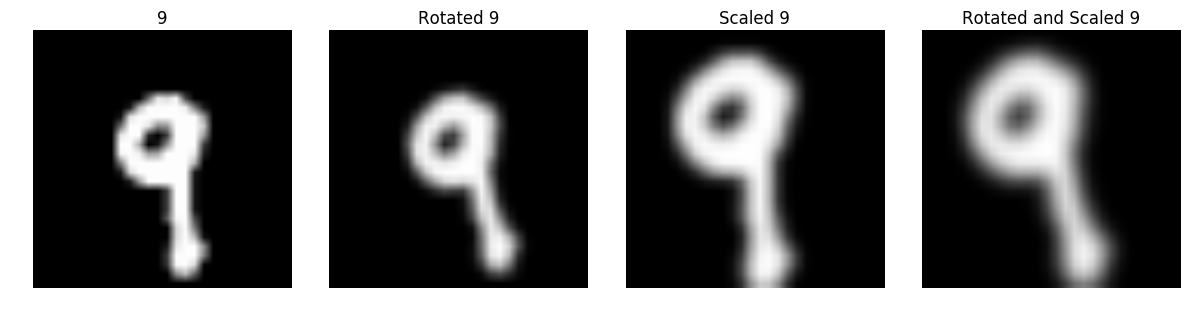

In [9]:
# Add rotated and scaled images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
img = data['train']['images'][0].reshape(28, 28)
label = data['train']['labels'][0]
plot_img(axes[0], img, '{:.0f}'.format(label))
plot_img(axes[1], rotate(img, reshape=False), 'Rotated {:.0f}'.format(label))
plot_img(axes[2], clipped_zoom(img, reshape=False), 'Scaled {:.0f}'.format(label))
plot_img(axes[3], clipped_zoom(rotate(img, reshape=False), reshape=False), 'Rotated and Scaled {:.0f}'.format(label))
fig.tight_layout()

In [ ]:
execute_algo(SoftmaxRegression(), 'SR')
execute_algo(KNN(), 'KNN')

Save CNN results
==========

In [10]:
orig_data = dict(train=read('digits/digit_train'), test=read('digits/digit_test'))

In [21]:
data = add_morphed_data(
    orig_data,
    zoom_range=np.arange(1, 1.31, 0.1),
    angle_range=range(-10, 11, 5))

c:\python\python35\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


20 mutations for each image


In [ ]:
model_dir = os.path.abspath('.').replace('\\', '/') + '/model/'
cnn = CNN(checkpoint_dir=model_dir)
cnn.fit(data['train']['images'], data['train']['labels'], epochs=200, save=True)

Model loaded


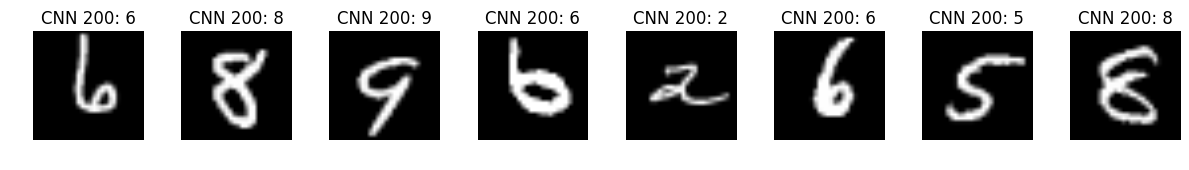

In [28]:
cnn = CNN(checkpoint_dir=model_dir)
cnn.restore('mnist_cnn_200')
execute_algo(cnn, 'CNN 200', train=False)